# Varta Threshold Calculation

The following figure illustrates the calculation that is going to be performed here.

![Computation Flowchart](../Images/Computation_Flowchart.png)

## Required Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Required SOC at Shipment

The SOC we require is based on an Excel workbook calculation.

**Activity**|**SOC**
:-----:|:-----:
Final Configuration SOC|0.73%
Second Storage SOC|4.75%
Fitting SOC|1.47%
Battery Variation|8.00%
Low Bat Threshold|10.00%
Total|24.95%

# Varta SOC

In [2]:
dfSOC= pd.read_csv("../Data/VartaSOC.txt",sep="\t", usecols=['SOC','VHA'],dtype={'SOC':np.int32,'VHA':np.float64})
dfSOC.SOC=dfSOC.SOC/100

f = interp1d(dfSOC.SOC, dfSOC.VHA)
vNom = f(0.25)
print(f'The nominal voltage with 25% SOC is {vNom:2.3f} V')


The nominal voltage with 25% SOC is 1.195 V


# Ratio Error

## Read Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dfRatio = pd.read_csv("../Data/Ratio_Raw_Data.txt",sep="\t", usecols=['Ratio'],dtype={'Ratio':np.float64})
dfRatio.describe()
dfRatio.head()

,Ratio
0,0.327312
1,0.328617
2,0.329617
3,0.331623
4,0.331720


## Histogram

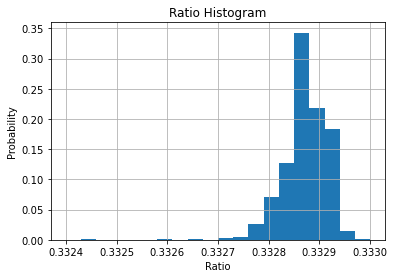

In [4]:
weights = np.ones_like(dfRatio.Ratio) / len(dfRatio.Ratio)
plt.hist(dfRatio.Ratio, weights=weights, bins=20, range=(0.3324, 0.333))
plt.xlabel('Ratio')
plt.ylabel('Probability')
plt.title('Ratio Histogram')
plt.grid(True)
plt.show()

## Estimate Variation Range from Empirical Distribution

In [5]:
dfSample = dfRatio.sample(1000, random_state=1)
z =[int(x<0.3327 or x>0.333) for x in dfSample.Ratio]
print(f'probability of value outside of 0.3327 to 0.333 is {sum(z)/1000:.2%}')
dfSample.describe()

probability of value outside of 0.3327 to 0.333 is 0.50%


,Ratio
count,1000.000000
mean,0.332872
std,0.000058
min,0.331720
25%,0.332851
50%,0.332877
75%,0.332904
max,0.333018


In [6]:
vRatioLow = np.quantile(dfRatio.Ratio, 0.001, axis=0)*3*vNom
print(vRatioLow)

1.191294782919066


In [7]:
# With Voltage Error
vRatioADC = vRatioLow-0.010
print(f"Threshold include battery, ratio, and ADC errors is {vRatioADC=:4.4} V")

Threshold include battery, ratio, and ADC errors is vRatioADC=1.181 V


## ADC Error

In [8]:
random.seed(10)
arrayADC = np.random.uniform(-0.01, 0.01, 1000)
z =[int(x<-0.0099) for x in arrayADC]
print(f'probability of value less than -0.0099 V is {sum(z)/1000:.2%}')
VADC_error=0.01


probability of value less than -0.0099 V is 0.60%


## Resistive loss

In [9]:
iLoad   = 2.75 # mA, my estimate for a potential iHA surge from a Macro RIC
Rseries = 6 # Ω for a new battery
vResistive = iLoad*Rseries
print(f"The resistive droop is {vResistive=:2.3f} mV")
# Compute overall droop
vTotalDroop = (vRatioADC-vResistive*0.001)
print(f'Lowest battery voltage expected from a good product is {vTotalDroop=:3.4f} V')


The resistive droop is vResistive=16.500 mV
Lowest battery voltage expected from a good product is vTotalDroop=1.1648 V


I am going to tell production that the threshold is now 1.165 V for the Varta batteries. This is a reasonable compromise value.